In [1]:
using Revise
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
import ProgressMeter

In [2]:
import ReactiveMP.messageout

In [3]:
include("helpers/data.jl")
include("helpers/form_constraint.jl")

In [4]:
function NN(y_,u_,θ)
    W1, b1 = reshape(θ[1:10],(5,2)), θ[11:15]
    W2, b2 = θ[16:20], θ[end]
    x = tanh.(W1*[y_;u_] .+ b1)
    W2'x + b2
end

melu(x) = clamp(x, tiny, Inf)

melu (generic function with 1 method)

In [5]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max(n, model_flow::FlowModel, params, h_prior, y_prev, u)
    
    dim = length(h_prior[1])

    # Extract parameters for flow, neural network and Gamma
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_f = params[del+1:end-2] # TODO: fix
    params_w = params[end-1:end]
    
    # initialize variables
    h       = randomvar(n)
    θ       = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim)))}  
    w       = randomvar() where {form_constraint = FixedMarginalConstraint(GammaShapeRate(melu(params_w[1]), melu(params_w[2])))}
    y       = datavar(Float64, n)

    ar_nodes = Vector{FactorNode}(undef, n)
    y_nodes = Vector{FactorNode}(undef, n)

    y_lat_1 = randomvar(n)
    y_lat_2 = randomvar(n)
    y_lat_3 = randomvar(n)
    
    neural_out = [NN(y_prev[i], u[i], params_f) for i in 1:n] #TODO: fix

    # create meta for AR
    AR_meta = ARMeta(Multivariate, dim, ARsafe())
    # create meta compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])

    θ   ~ MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim))
    w   ~ GammaShapeRate(melu(params_w[1]), melu(params_w[2]))
    
    h_prev = h_0
    for t in 1:n
        # specify latent state
        ar_nodes[t], h[t] ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta}
        y_lat_1[t] ~ Flow(h[t]) where { meta = Flow_meta}
        y_lat_2[t] ~ dot(y_lat_1[t], ones(dim))
        y_lat_3[t] ~ y_lat_2[t] + neural_out[t]
        y_nodes[t], y[t] ~ NormalMeanPrecision(y_lat_3[t], w)
        h_prev = h[t]
    end

    return h, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_nodes
end

nonlinear_max (generic function with 1 method)

In [6]:
function nonlinear_max_inference(observations,observations_prev, controls, model_flow::FlowModel, params; 
                                 h_prior=(zeros(2), 0.1*diageye(2)), vmp_its=10)
    # fetch number of samples
    n = length(observations)

    # define model
    model, (h, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_nodes) = nonlinear_max(n, model_flow, params, h_prior,
                                                                            observations_prev, controls,
                                                                            options = (limit_stack_depth = 500, ))
    
    h_buffer = Vector{Marginal}(undef, n)
    θ_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    w_buffer = nothing
    
    h_sub = subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    w_sub = subscribe!(getmarginal(w), (x) -> w_buffer = x)
    θ_sub = subscribe!(getmarginal(θ), (x) -> θ_buffer = x)
    y_out_sub = subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))

    setmarginal!(w, GammaShapeRate(1.0, 1.0))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(dim), diageye(dim)))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # unsubscribe
    unsubscribe!(fe_sub)
    unsubscribe!(h_sub)
    unsubscribe!(w_sub)
    unsubscribe!(θ_sub)
    
    # return the marginal values
    return fe_buffer, h_buffer, w_buffer, y_out_buffer, θ_buffer
    
end

nonlinear_max_inference (generic function with 1 method)

In [7]:
# specify flow model
dim = 2
model_flow = FlowModel(dim,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow())
    )
);

In [108]:
Random.seed!(42)

n_samples = 1000
u = 3 .* sin.(collect(1:n_samples+10))
order_y, order_u, order_e = 1, 1, 1
y_lat, y_obs, h_gen = generate_data(n_samples, narx, Dict(:order_y=>order_y, :order_u=>order_u, :order_e=>order_e),
                                                     Dict(:er_var=>1e-2, :u=>u));

In [109]:
observations_prev = y_obs[1:end-1]
observations      = y_obs[2:end];
controls          = u[order_u:end];

In [110]:
train_size = 800
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size]
X_test, Y_test, U_test = observations_prev[train_size+1:end], observations[train_size+1:end], controls[train_size+1:end];

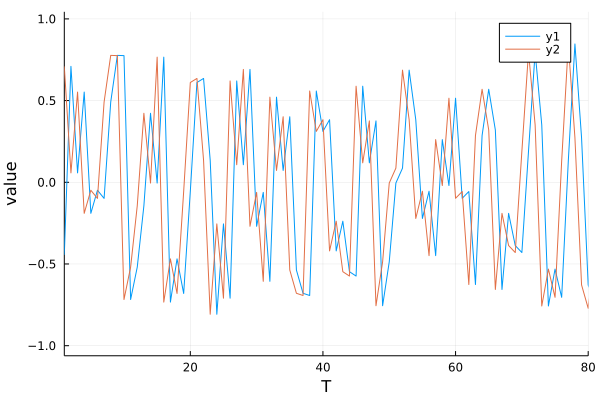

In [111]:
from, to = 1, 80
plot(X_train, xlims=(1, train_size))
plot!(Y_train, xlims=(from, to), xlabel="T", ylabel="value")

In [112]:
flow_param_len = nr_params(model_flow)
NN_param_len = 21
model_params = randn(flow_param_len+NN_param_len+2); #Flow, NN, Gamma

In [113]:
fe, h, w, y_out, θ = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, model_params, vmp_its=10);

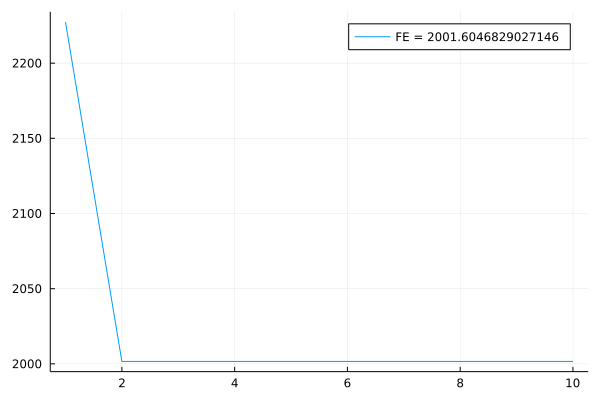

In [114]:
gr()
plot(fe, label="FE = $(fe[end])")

In [115]:
# Optimization function
function FE(params)
    fe, h, w, y_out, θ = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, params, 
                                                 h_prior=(zeros(2), 0.1*diageye(2)), 
                                                 vmp_its=1)
    return fe[end]
end;

In [116]:
FE(model_params)

2227.371161258965

In [117]:
using Optim
res = optimize(FE, model_params, GradientDescent(), Optim.Options(store_trace = true, show_trace = true), autodiff=:forward)

Iter     Function value   Gradient norm 
     0     2.227371e+03     1.678348e+03
 * time: 0.00019288063049316406
     1     2.225953e+03     1.678346e+03
 * time: 38.42374897003174
     2     2.223894e+03     1.678302e+03
 * time: 75.66161584854126
     3     2.222949e+03     1.678278e+03
 * time: 110.50492691993713
     4     2.222441e+03     1.678269e+03
 * time: 147.56717681884766
     5     2.222203e+03     1.678249e+03
 * time: 187.0405888557434
     6     2.222123e+03     1.676621e+03
 * time: 225.66335487365723
     7     2.219109e+03     1.671040e+03
 * time: 265.3405740261078
     8     1.901708e+03     4.991329e+02
 * time: 269.8271448612213
     9     1.901212e+03     4.449433e+02
 * time: 312.9421899318695
    10     1.900786e+03     4.225589e+02
 * time: 352.8423478603363
    11     1.897281e+03     4.218928e+02
 * time: 397.7433350086212
    12     1.897281e+03     4.218928e+02
 * time: 472.1643879413605
    13     1.897281e+03     4.218928e+02
 * time: 472.1648128032684

 * Status: success

 * Candidate solution
    Final objective value:     1.897281e+03

 * Found with
    Algorithm:     Gradient Descent

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 4.22e+02 ≰ 1.0e-08

 * Work counters
    Seconds run:   472  (vs limit Inf)
    Iterations:    13
    f(x) calls:    600
    ∇f(x) calls:   600


In [118]:
inf_params = Optim.minimizer(res)
FE(inf_params)

1897.281382908117

In [119]:
inf_params = Optim.minimizer(res)
fe, h, w, y_out, θ = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, inf_params, vmp_its=100);

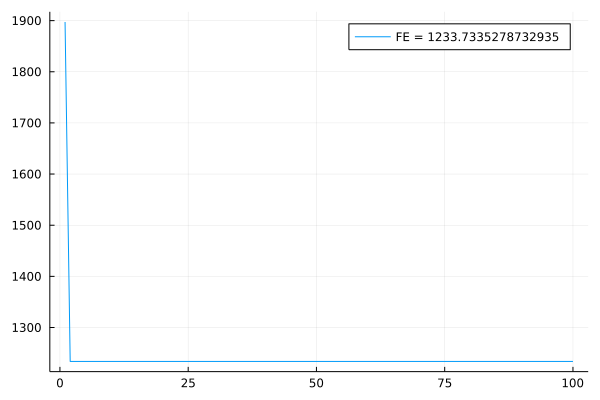

In [120]:
plot(fe[1:end], label="FE = $(fe[end])")

In [121]:
from, to = 100, 300

(100, 300)

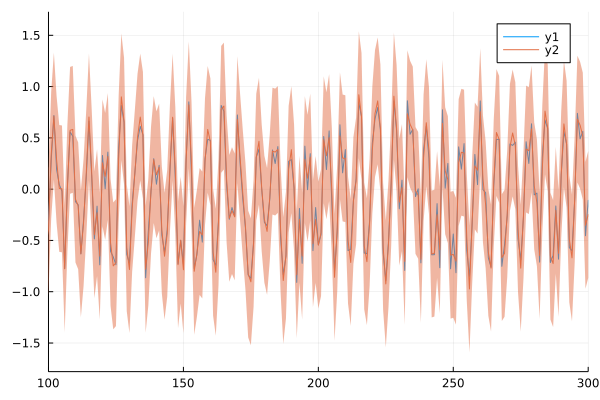

In [122]:
my, vy = mean.(y_out), cov.(y_out)
plot(Y_train, xlims=(from, to))
plot!(my, ribbon=sqrt.(vy))

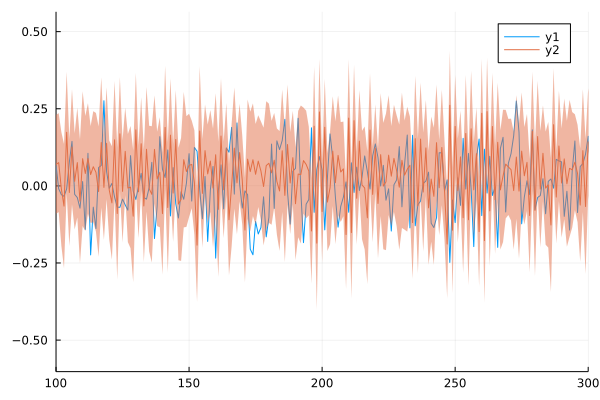

In [123]:
mh, vh = mean.(h), cov.(h)
plot(h_gen)
plot!(first.(mh), ribbon=sqrt.(first.(vh)), xlims=(from, to))

### Prediction model (TODO)

In [124]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_prediction(model_flow::FlowModel, params, h_prior, w_prior, y_prev, u)
    
    dim = length(h_prior[1])
    # initialize variables
    
    y_pred       = datavar(Float64)
    
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_f = params[del+1:end-2]
    params_w = params[end-1:end]

    θ   = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim)))}  
    w   = randomvar() where {form_constraint = FixedMarginalConstraint(GammaShapeRate(melu(params_w[1]), melu(params_w[2])))}
    h_0 = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(h_prior[1], h_prior[2]))}

    sigmoid_pred = NN(y_prev, u, params_f)

    # compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    θ   ~ MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim))
    w   ~ GammaShapeRate(melu(params_w[1]), melu(params_w[2])) where {q=MeanField()}
    
    # specify transformed latent value
    
    AR_meta = ARMeta(Multivariate, dim, ARsafe())

    # specify observations
    
    ar_node, h ~ AR(h_0, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta}
    
    y_lat_1 ~ Flow(h) where { meta = Flow_meta, q = FullFactorisation() }
    
    y_lat_2 ~ dot(y_lat_1, ones(dim))
    
    y_lat_3 ~ y_lat_2 + sigmoid_pred

    y_node, y ~ NormalMeanPrecision(y_lat_3, w) where { q = q(y, y_lat_3)q(w) }
    
    y_pred ~ NormalMeanPrecision(y, 1e-12)
    
    return h, h_0, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_node, y_pred
end

nonlinear_max_prediction (generic function with 2 methods)

In [130]:
function nonlinear_max_prediction(observation_prev::T, control::T, model_flow::FlowModel, params; 
                                  h_prior=(ones(2), diageye(2)), w_prior=(1.0, 1.0), vmp_its = 50) where T<:Float64

    # define model
    model, (h, h_0, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_node, y_pred) = nonlinear_max_prediction(model_flow, params, h_prior, w_prior,
                                                                                                   observation_prev, control,
                                                                                                   options = (limit_stack_depth = 500, ))
    
    h_buffer = nothing
    h0_buffer = nothing
    y_out_buffer = nothing
    w_buffer = nothing
    y_pred_buffer = nothing
    
    h_sub = subscribe!(getmarginal(h), (x) -> h_buffer = x)
    h0_sub = subscribe!(getmarginal(h_0), (x) -> h0_buffer = x)
    y_pred_sub = subscribe!(getmarginal(y), (x) -> y_pred_buffer = x)
    w_sub = subscribe!(getmarginal(w), (x) -> w_buffer = x)

    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginal!(w, GammaShapeRate(w_prior[1], w_prior[2]))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim)))
    setmarginal!(y, NormalMeanPrecision(0.0, 1.0))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y_pred, 0.0)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, h0_buffer, w_buffer, y_pred_buffer
    
end

nonlinear_max_prediction (generic function with 2 methods)

In [126]:
# TODO: Wrong, must be fixed

predictions = []
h_pred = (mean(h[end]), precision(h[end]))
h0_pred = (mean(h[end]), precision(h[end]))
w_pred = (shape(w), rate(w))
rw = []
for i in 1:length(X_test)
    fe, h_pred, h0_pred, w_pred, y_pred = nonlinear_max_prediction(X_test[i], U_test[i], model_flow, inf_params, h_prior=h_pred, w_prior=w_pred, vmp_its=1)
    w_pred = (shape(w_pred), rate(w_pred))
    push!(predictions, y_pred)
    h_pred = (mean(h_pred), precision(h_pred))
#     push!(rw, [h_pred[1], h_pred[2]])
end

### Alternative

In [131]:
function transition(γ, order)
    V = zeros(order, order)
    V[1] = 1/γ
    return V
end

function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [132]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_prediction(model_flow::FlowModel, params, w, h_prior, y_prev, u)
    
    dim = length(h_prior[1])

    A = shift(dim) # transition matrix
    V = transition(w, dim)
    # initialize variables
    
    y_pred   = datavar(Float64)
    
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_f = params[del+1:end-2]
    params_w = params[end-1:end]

    h_0 = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(h_prior[1], h_prior[2]))}

    NN_pred = NN(y_prev, u, params_f)

    # compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    
    Ah ~ A*h_0
    h ~ MvNormalMeanCovariance(Ah, V) where {q = q(Ah, h)q(V)}
    
    y_lat_1 ~ Flow(h) where { meta = Flow_meta, q = FullFactorisation() }
    
    y_lat_2 ~ dot(y_lat_1, ones(dim))
    
    y_lat_3 ~ y_lat_2 + NN_pred

    y_node, y ~ NormalMeanPrecision(y_lat_3, w) where { q = q(y, y_lat_3)q(w) }
    
    y_pred ~ NormalMeanPrecision(y, 1e-12)
    
    return h, h_0, y_lat_1, y_lat_2, y_lat_3, y, y_node, y_pred
end

nonlinear_max_prediction (generic function with 2 methods)

In [133]:
function nonlinear_max_prediction(observation_prev::T, control::T, model_flow::FlowModel, params; 
                                  h_prior=(ones(2), diageye(2)), w=1.0, vmp_its = 50) where T<:Float64

    # define model
    model, (h, h_0, y_lat_1, y_lat_2, y_lat_3, y, y_node, y_pred) = nonlinear_max_prediction(model_flow, params, w, h_prior,
                                                                                                    observation_prev, control,
                                                                                                    options = (limit_stack_depth = 500, ))
    
    h_buffer = nothing
    h0_buffer = nothing
    y_out_buffer = nothing
    y_pred_buffer = nothing
    
    h_sub = subscribe!(getmarginal(h), (x) -> h_buffer = x)
    h0_sub = subscribe!(getmarginal(h_0), (x) -> h0_buffer = x)
    y_pred_sub = subscribe!(getmarginal(y), (x) -> y_pred_buffer = x)

    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginal!(y, NormalMeanPrecision(0.0, 1.0))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y_pred, 0.0)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, h0_buffer, y_pred_buffer
    
end

nonlinear_max_prediction (generic function with 2 methods)

In [134]:
predictions = []
h_pred = (mean(h[end]), precision(h[end]))
h0_pred = (mean(h[end]), precision(h[end]))
w_pred = mean(w)
rw = []
for i in 1:length(X_test)
    fe, h_pred, h0_pred, y_pred = nonlinear_max_prediction(X_test[i], U_test[i], model_flow, inf_params, h_prior=h_pred, w=w_pred, vmp_its=10)
    push!(predictions, y_pred)
    h_pred = (mean(h_pred), precision(h_pred))
#     push!(rw, [h_pred[1], h_pred[2]])
end

In [135]:
w_pred = mean(w)

2.6158054060598817

In [136]:
mx, vx = mean.(predictions), cov.(predictions)

([0.9940130514045686, 0.2616181191739888, -1.6986210774324413, -1.4338208192743376, -0.45342201502298185, 1.179616166353298, 0.15781413013797924, 0.4442017972587047, -1.7436288562309028, -0.8796823597299789  …  -1.474015394482143, -1.7202542417998978, -0.6117229819969093, 1.1872867206381685, 0.6385676663797835, -0.14573823931679405, -1.4884018998338042, -0.5185676640612532, -0.9565384343663029, -0.24567178436796067], [8.751171871881992, 15.963369759285678, 15.96336975928674, 15.96336975914185, 15.963369759155205, 15.963369759234906, 15.963369759274299, 15.963369759285285, 15.963369759285014, 15.963369759139683  …  15.96336975922683, 15.963369759153085, 15.963369759140807, 15.963369759217283, 15.963369759274352, 15.963369759280242, 15.963369759267689, 15.96336975915234, 15.963369759227522, 15.963369759185385])

In [151]:
test_from, test_to = 1, 50

(1, 50)

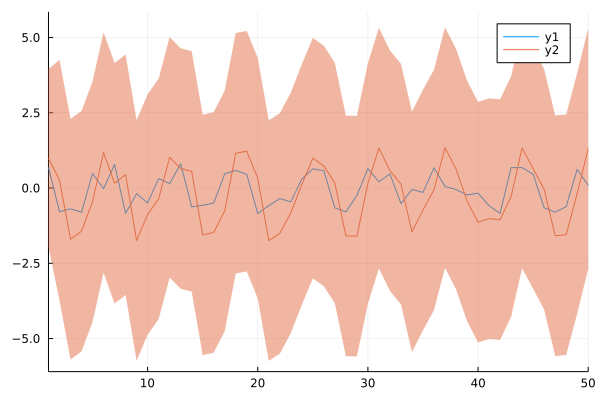

In [152]:
plot(Y_test)
plot!(mx, ribbon=sqrt.(vx), xlims=(test_from, test_to))

In [153]:
n_output = [NN(y_prev, u, inf_params[13:end]) for (y_prev, u) in zip(X_test, U_test)]

200-element Vector{Float64}:
  1.1875774511765607
  0.7107598970894478
 -1.249479299553971
 -0.9846790414007207
 -0.004280237133576281
  1.6287579442726359
  0.6069559080551747
  0.8933435751709239
 -1.2944870783523583
 -0.4305405818475493
  0.0895720187219996
  1.4688757789984626
  1.098821588739328
  ⋮
  1.6332934547017854
 -0.07555818111822499
 -1.0248736166057777
 -1.2711124639307352
 -0.16258120411018417
  1.6364284985563318
  1.0877094443047959
  0.30340353858843383
 -1.0392601219543431
 -0.06942588617291423
 -0.5073966564816255
  0.20346999352549144

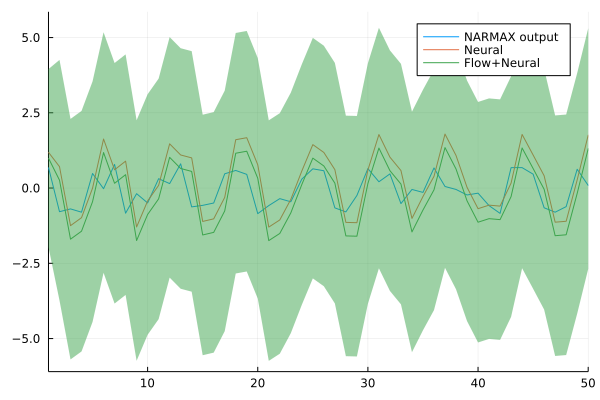

In [154]:
plot(Y_test, label="NARMAX output")
plot!(n_output, label="Neural")
plot!(mx, ribbon=sqrt.(vx), label="Flow+Neural", xlims=(test_from, test_to))

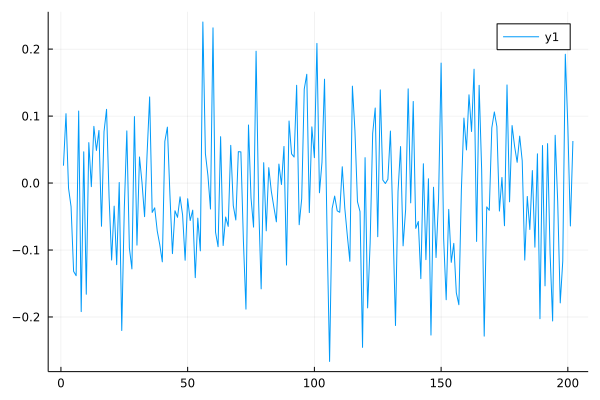

In [156]:
plot(h_gen[800:end])
# plot!(first.(rw), ribbon=sqrt.(last.(rw)))